# 🩺 당뇨병 - 예측 (Classification)
🎯 건강 지표(BMI, 혈압, 나이 등)를 바탕으로 당뇨병 발병 여부를 예측하는 이진 분류 문제

## ✅ 1. 데이터 탐색 및 전처리

### 📌 1-1. 데이터 불러오기 및 기본 정보 확인

In [1]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("/Users/lee_hyejoo/Desktop/hyejoo/학교/3학년 1학기/머신러닝/중간_대체/당뇨병_예측, Pima Indians Diabetes - Binary Classification/diabetes.csv")

# 상위 5개 행 확인
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


➡️ 전체 768개의 샘플, 9개의 변수(8개의 입력 변수 + 1개의 타겟 변수 Outcome)로 구성

➡️ 타겟 변수 Outcome은 당뇨병 여부
- 1: 당뇨병 있음
- 0: 당뇨병 없음

### 📌 1-2. 변수 정보 및 결측치 탐색

In [5]:
# 데이터 구조와 변수 타입 확인
df.info()

# 각 변수별 0 값(사실상 결측) 개수 확인
(df == 0).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 54.1 KB


Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

➡️ 데이터 타입은 int64와 float64로 구성되어 있으며, 표면상 결측치는 없음 (non-null 모두 768)

➡️ 하지만 도메인 지식을 반영하면 다음과 같은 변수에서 0값은 사실상 결측으로 판단됨:
- Glucose, BloodPressure, SkinThickness, Insulin, BMI
- 이 변수들은 의학적으로 0이 나올 수 없는 항목이므로 추후 전처리에서 중앙값으로 대체(Median Imputation) 필요

---

### 📌 1-3. 변수 간 상관관계 분석 (히트맵)

/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Gl

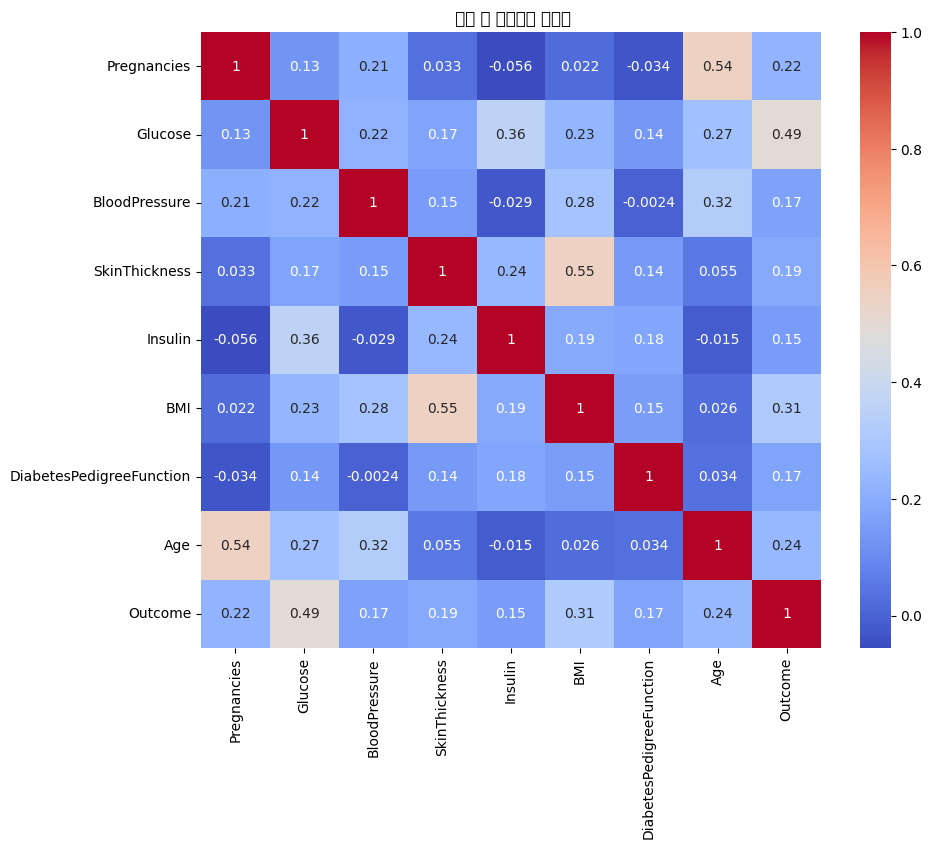

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title(" 변수 간 상관관계 히트맵")
plt.show()

🔍 해석

1. 당뇨병 발생 여부와의 상관관계
- Glucose (상관계수 ≈ 0.49)

    → 당 수치는 당뇨병 여부와 가장 높은 양의 상관관계를 보임

    → 높은 포도당 수치는 당뇨 가능성을 강하게 시사함

- BMI (상관계수 ≈ 0.31)

    → 체질량지수 역시 당뇨병과 의미 있는 양의 상관관계

    → 비만은 당뇨의 주요 위험 요인 중 하나

- Age (상관계수 ≈ 0.24)

    → 나이가 많을수록 당뇨 발생률도 높아지는 경향
- Pregnancies (상관계수 ≈ 0.22)

    → 임신 횟수가 많을수록 당뇨 발생 가능성도 높아지는 패턴 (특히 임신성 당뇨 가능성 반영)

2. 다중공선성(Multicollinearity) 의심 변수
- SkinThickness 와 BMI : 상관계수 0.55

    → 피하지방 두께와 BMI는 유사한 생리적 특성 반영


---

### 📌 1-4. 이상치 및 변수 분포 확인 - 연속형 변수

/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/4266656917.py:19: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/4266656917.py:19: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/4266656917.py:19: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/4266656917.py:19: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/4266656917.py:19: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel

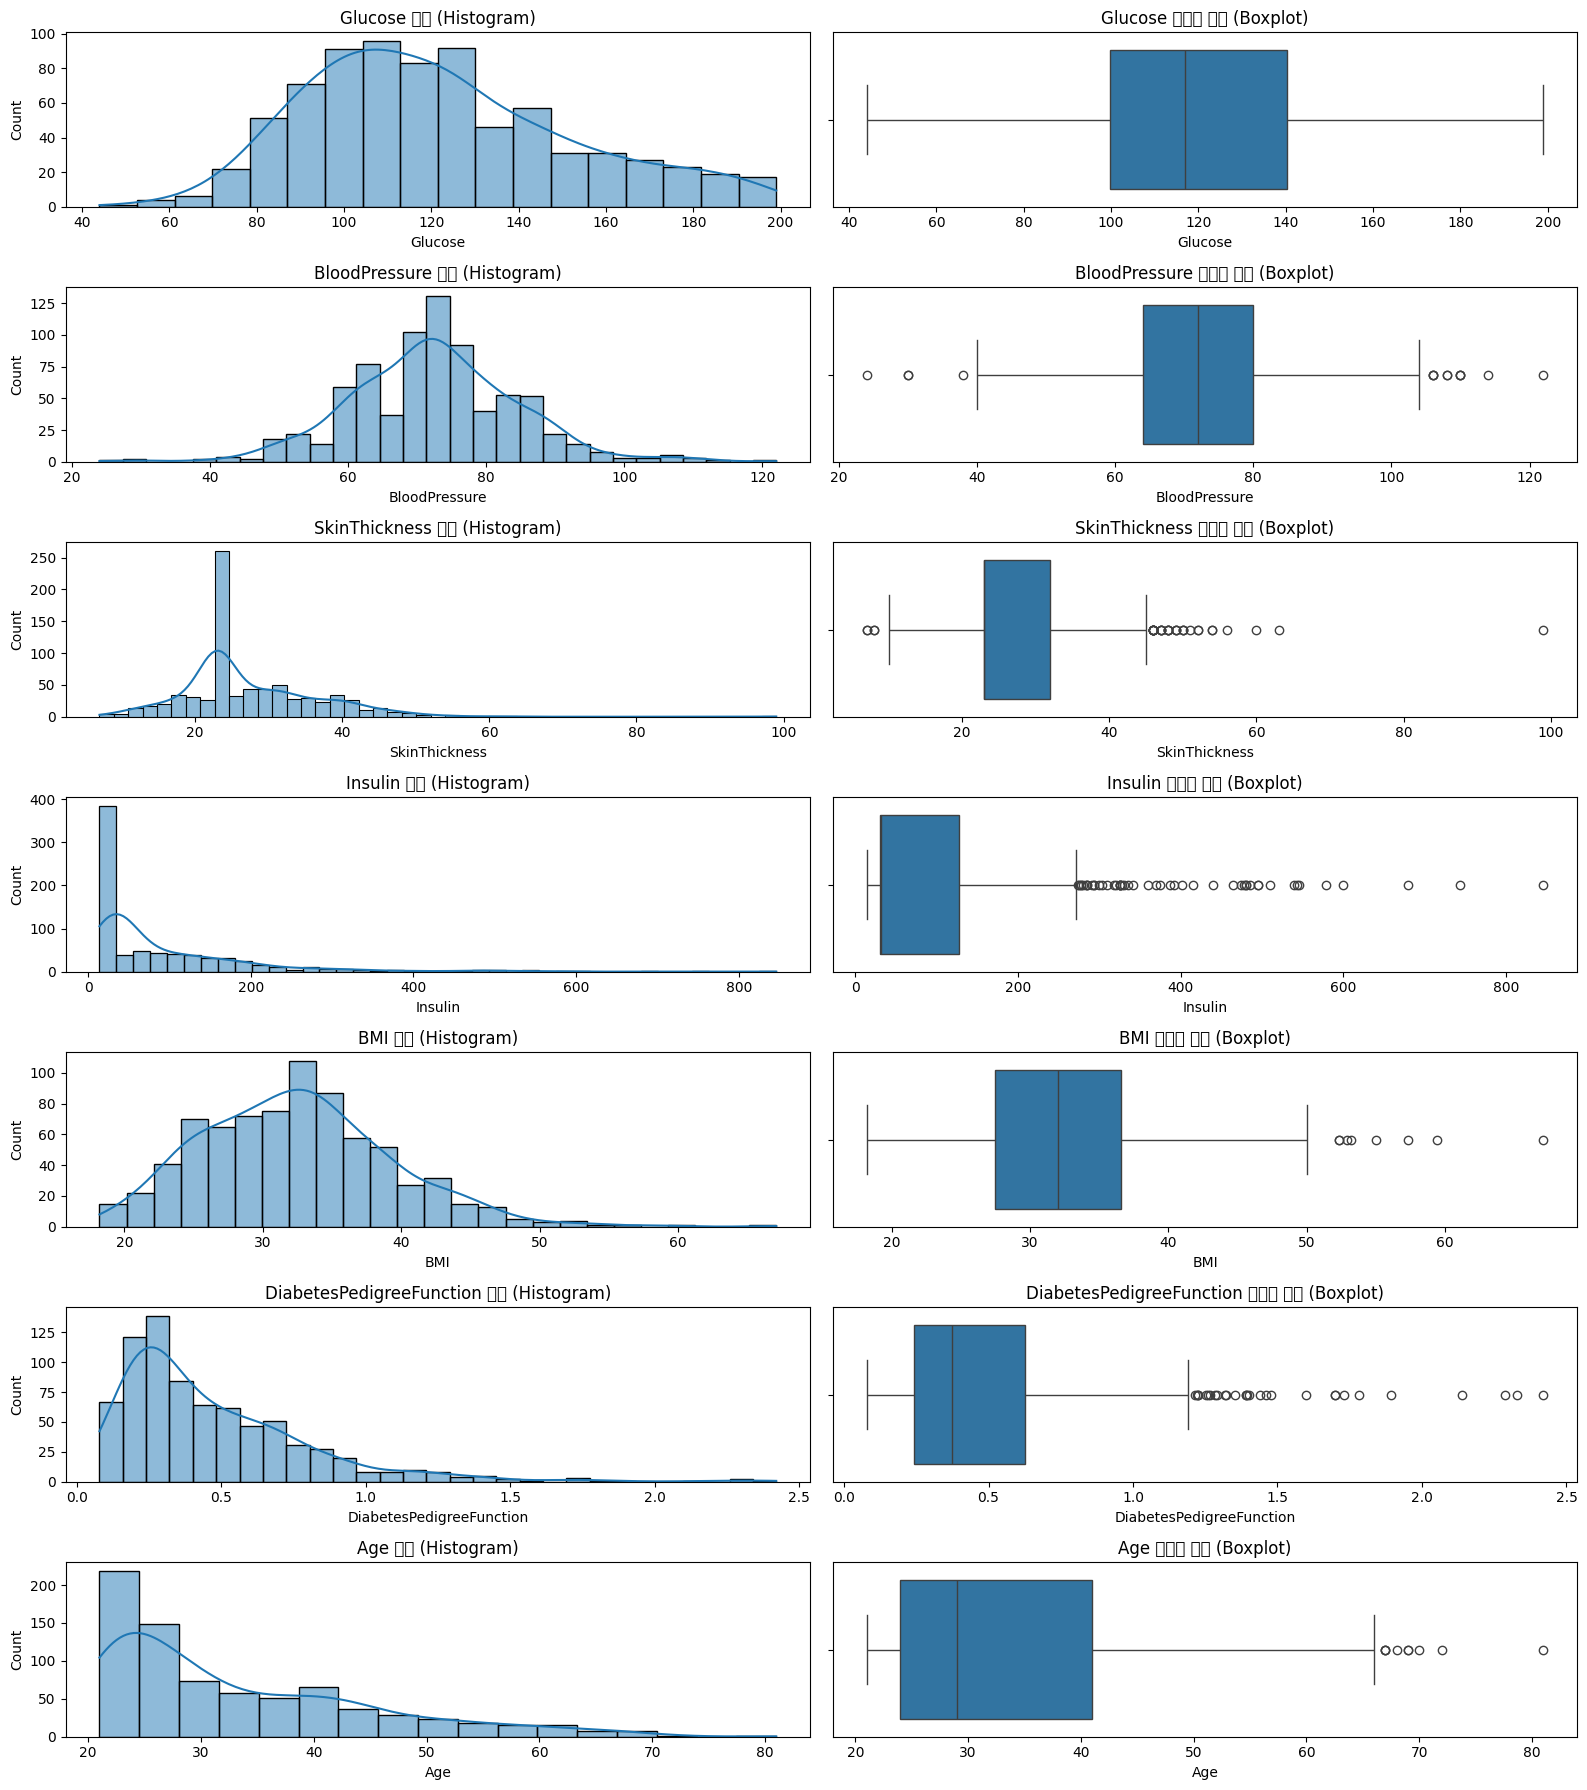

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 연속형 변수 목록
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# 분포 확인 (히스토그램 + 박스플롯)
plt.figure(figsize=(16, 18))

for i, col in enumerate(features):
    plt.subplot(7, 2, 2*i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} 분포 (Histogram)")
    
    plt.subplot(7, 2, 2*i+2)
    sns.boxplot(x=df[col])
    plt.title(f"{col} 이상치 탐지 (Boxplot)")

plt.tight_layout()
plt.show()

🔍 해석

변수 | 분포 형태 | 이상치 | 특징 및 해석

Glucose | 비교적 정규 분포 | 거의 없음 | 당 수치 변수로서, 당뇨 예측에서 매우 중요한 역할을 함. 정규 분포에 가까워 모델 입력에 적합

BloodPressure | 좌우 대칭이나 낮은 수치에 집중 | 소수 존재 | 0 값은 생리적으로 불가능하므로 결측값으로 처리 필요. 이상치 비율은 적은 편

SkinThickness | 오른쪽으로 치우침 (Positive Skew) | 다수 존재 | 0이 많으며, 높은 값에 일부 극단값 존재. 중간값 대체 및 로그 변환 고려 가능

Insulin | 심한 오른쪽 치우침 | 매우 많음 | 대다수가 0이며, 이상치가 상당히 많음. 전처리에서 로그 스케일이나 중위수 대체 필요

BMI | 거의 정규 분포 | 일부 존재 | 전반적으로 안정적이나, 상위 몇 개의 이상치는 제거 고려 대상

DiabetesPedigreeFunction | 오른쪽 치우침 | 일부 있음 | 유전 계수를 나타내며, 대부분 0~1.5 사이. 2 이상은 이상치로 간주 가능

Age | 오른쪽 치우침 | 소수 | 당뇨 데이터이지만 20대 이하도 다수 존재. 고령 환자 예측에 유의할 필요 있음

➡️ Glucose, BMI는 거의 정규 분포로 스케일링만 적용하면 바로 사용할 수 있음

➡️ Insulin, SkinThickness는 이상치가 심하고 분포 왜곡이 크므로, 중앙값 대체 + 정규화를 반드시 수행

➡️ 대부분 변수에 0값이 결측처럼 존재하며 이는 생리학적으로 불가능하므로 다음 단계에서 결측치 처리 필요

----

### 📌 1-4. 이상치 및 변수 분포 확인 - 이산형 변수

/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/1557007026.py:19: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_22079/1557007026.py:19: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lee_hyejoo/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


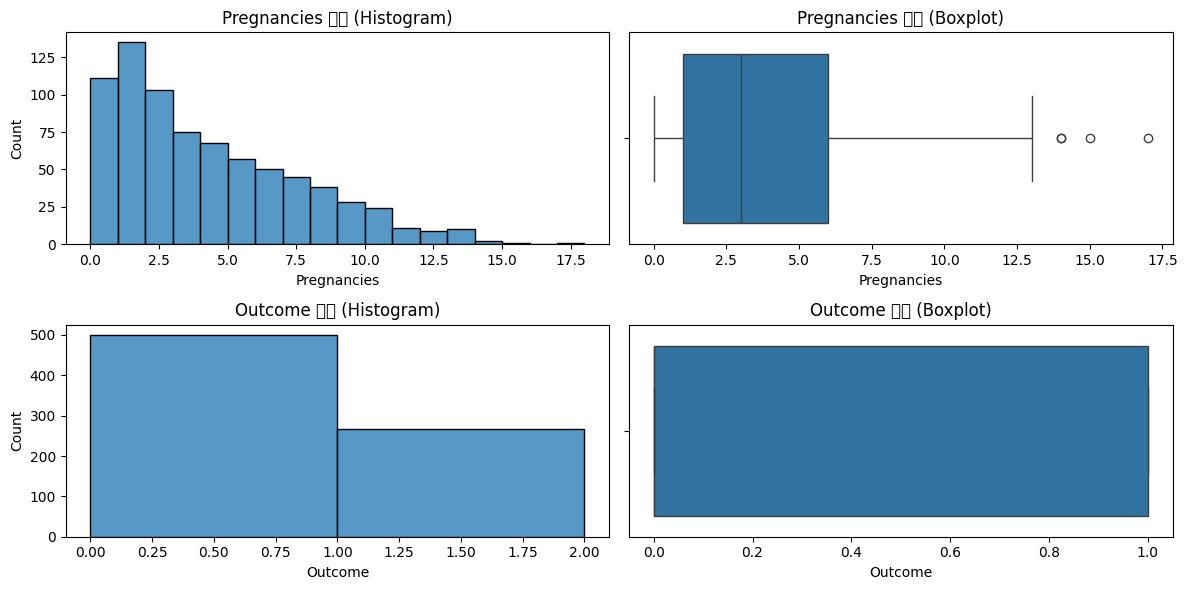

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Pregnancies와 Outcome은 이산형 변수
discrete_features = ['Pregnancies', 'Outcome']

# subplot 그리기
fig, axes = plt.subplots(nrows=len(discrete_features), ncols=2, figsize=(12, 6))

for idx, feature in enumerate(discrete_features):
    # 히스토그램
    sns.histplot(df[feature], kde=False, bins=range(df[feature].min(), df[feature].max() + 2), ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} 분포 (Histogram)')

    # 박스플롯
    sns.boxplot(x=df[feature], ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} 분포 (Boxplot)')

plt.tight_layout()
plt.show()

🔍 해석

1. Pregnancies

구분 | 설명

히스토그램 | 대부분의 임신 횟수는 0~5회 사이에 집중되어 있음. 특히 0, 1, 2회가 가장 많고, 그 이후로는 횟수가 점점 줄어드는 우측 긴꼬리 분포 (right-skewed) 형태를 보임

박스플롯 | 중앙값은 약 3~4회, 13회 이상부터 이상치(outlier)로 간주. 매우 높은 임신 횟수는 소수이지만 존재함

의의 | 대부분의 환자는 임신 횟수가 5회 이하이며, 일부 극단적인 값은 모델 학습 시 영향력이 클 수 있음 → 이상치 처리 여부 고려 가능

2. Outcome

구분 | 설명

히스토그램 | Outcome = 0 (정상)이 약 500건 이상, Outcome = 1 (당뇨 환자)는 약 260건 정도로 불균형한 분포

박스플롯 | 박스플롯의 형태는 사실상 막대그래프와 동일하게 보이며, 이진 분류 변수는 중앙값 0.5 기준으로 binary하게 나뉨

의의 | 데이터가 **불균형(binary imbalance)**함. 따라서 모델 성능 비교 시 Recall, AUC, F1-score와 같은 지표를 신중히 고려해야 함. 또한 SMOTE 등의 불균형 데이터 처리 기법이 필요할 수 있음

➡️ Pregnancies: 이산형 정수 변수, 이상치 존재, 분포 치우침 있음

➡️ Outcome: 이진 분류 레이블, 불균형 데이터로 성능 지표 및 전처리 필요

---

### 📌 1-5. 결측치 처리 (0값 → 중앙값 대체)

In [13]:
# 의미상 결측치(0) → 중앙값으로 대체
zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for column in zero_as_missing:
    median = df[column].median()
    df[column] = df[column].replace(0, median)

# 0이 존재하는지 확인
print(df[zero_as_missing].eq(0).sum())

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


### 📌 1-6. 데이터 정규화 (Feature Scaling)
- MinMaxScaler를 사용하여 0~1 사이로 정규화
- 스케일링 대상 변수: 모든 입력 변수 (Outcome 제외)

In [14]:
from sklearn.preprocessing import MinMaxScaler

# 타겟 변수 분리
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# 정규화
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 스케일링 결과 확인
X_scaled.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501008,0.493742,0.221029,0.096938,0.291430,0.168179,0.204015
std,0.198210,0.196376,0.123435,0.100315,0.126860,0.140601,0.141473,0.196004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.173913,0.019832,0.190184,0.070773,0.050000
50%,0.176471,0.470968,0.489796,0.173913,0.020733,0.282209,0.125747,0.133333
75%,0.352941,0.620968,0.571429,0.271739,0.136118,0.376278,0.234095,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


🔍 해석
- min, max가 모두 0~1 사이	→ 정규화가 올바르게 수행됨
- 각 변수의 평균(mean)*과 표준편차(std)	→ 스케일은 달라도 각 변수의 상대적 분포가 유지됨

---

## 🤖 2. 모델 학습 및 비교

### 📌 2-1. 기본 모델 - 로지스틱 회귀

In [23]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 📌 2-2. 기본 모델 - Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

### 📌 2-3. 고급 모델 - Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 📌 2-4. 고급 모델 - XGBoost

In [27]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### 📌 2-5. 고급 모델 - LightGBM

In [26]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(random_state=42)

### 📌 2-6. 딥러닝 모델 - DNN

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔍 해석
- 정확도(Accuracy)는 약 72.08%로 비교적 안정적인 예측 성능을 보임
- Recall(재현율)이 0.6828로, 실제 당뇨 환자 중 약 68%를 제대로 예측
- 의료 데이터에서는 Recall이 중요한데, Logistic Regression보다 약간 향상됨
- Precision도 0.69 정도로, 예측한 양성 중 실제 양성이 꽤 되는 편

➡️ DNN은 비선형 관계에 강한 모델로, 단순 선형 모델보다 더 복잡한 패턴을 잡아내는 데 효과적

---

## 📊 3. 모델 성능 평가 및 비교

In [34]:
from sklearn.metrics import classification_report

#  3-1. Logistic Regression
y_pred_lr = lr_model.predict(X_test)

#  3-2. Decision Tree
y_pred_dt = dt_model.predict(X_test)

#  3-3. Random Forest
y_pred_rf = rf_model.predict(X_test)

#  3-4. XGBoost
y_pred_xgb = xgb_model.predict(X_test)

#  3-5. LightGBM
y_pred_lgbm = lgbm_model.predict(X_test)

#  3-6. DNN
y_pred_dnn = (dnn_model.predict(X_test) > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

#  모델별 평가 결과 정리
results_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "DNN"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_dnn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgbm),
        precision_score(y_test, y_pred_dnn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgbm),
        recall_score(y_test, y_pred_dnn)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgbm),
        f1_score(y_test, y_pred_dnn)
    ]
})

results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.701299,0.583333,0.518519,0.549020
1,Decision Tree,0.785714,0.690909,0.703704,0.697248
2,Random Forest,0.746753,0.653061,0.592593,0.621359
3,XGBoost,0.772727,0.702128,0.611111,0.653465
4,LightGBM,0.727273,0.615385,0.592593,0.603774
5,DNN,0.746753,0.666667,0.555556,0.606061


🔍 해석

1. Decision Tree
- 가장 높은 Accuracy (0.7857) 와 높은 Recall (0.7037) 을 동시에 달성
- 의료 문제에서 중요한 Recall(재현율) 면에서도 가장 우수
- Precision도 0.69로 높은 편
- 단점: 모델이 단순하고 과적합 가능성이 있음 (깊이에 따라 성능 흔들릴 수 있음)

2. XGBoost
- Precision (0.7021) 최고 기록
- F1 Score도 0.6535로 높은 수준이며, Accuracy도 0.77로 우수함
- 전체적으로 고르게 뛰어난 성능
- Recall은 0.61로 Decision Tree보다 살짝 낮음

3. Random Forest & DNN
- 두 모델 모두 Accuracy는 0.7468로 동일
- Random Forest는 Precision과 Recall 균형이 괜찮고, DNN은 Precision이 다소 높지만 Recall은 낮음
- DNN은 향후 하이퍼파라미터 조정으로 성능 개선 여지 있음

4. LightGBM
- Precision(0.6154), Recall(0.5926), F1(0.6038)으로 전체적으로 준수하지만 XGBoost에 비해 약간 밀림
- 속도 빠르고 확장성 좋지만, 과제에서는 성능 기준으로는 2순위로 밀림

5. Logistic Regression
- 가장 기본적인 선형 모델
- 모든 지표에서 가장 낮음. 특히 Recall(0.5185)이 낮아 의료 데이터에서 중요도가 떨어짐
- 해석 용이성이 장점이지만 성능은 부족

구분 | 모델 | 장점 | 단점

🥇 추천 | Decision Tree | 높은 Recall, 우수한 전반적 성능 | 단순 구조, 과적합 주의

🥈 후보 | XGBoost | 높은 Precision, 전반적 안정성 | 약간 낮은 Recall

보완 | DNN / Random Forest | 중간 성능, 튜닝 여지 있음 | 성능 약간 밀림

참고 | Logistic Regression | 해석 쉬움 | 성능 낮음 (특히 Recall)

---